In [1]:
import time
import os
import random as rd
import random
import pickle
import pandas as pd
import numpy as np
import torch
from scipy.io import loadmat
import argparse
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Some Common Function

In [2]:
import scipy.sparse as sp
import copy as cp
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_auc_score, average_precision_score
from collections import defaultdict

# load the data, including relations, adj, features and labels.
def load_data(data):

    data_file = loadmat('data/YelpChi.mat')
    labels = data_file['label'].flatten()
    feat_data = data_file['features'].todense().A
    # load the preprocessed adj
    with open('data/yelp_rur_adjlists.pickle', 'rb') as file:
        relation1 = pickle.load(file)
    file.close()
    with open('data/yelp_rtr_adjlists.pickle', 'rb') as file:
        relation2 = pickle.load(file)
    file.close()
    with open('data/yelp_rsr_adjlists.pickle', 'rb') as file:
        relation3 = pickle.load(file)
    file.close()
    with open('data/yelp_homo_adjlists.pickle', 'rb') as file:
        homo = pickle.load(file)
    file.close()
        
    return [homo, relation1, relation2, relation3], feat_data, labels

# normalize the features
def normalize(mx):
    rowsum = np.array(mx.sum(1)) + 0.01
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

# split to the possitive and negative items
def pos_neg_split(nodes, labels):
    pos_nodes = []
    neg_nodes = cp.deepcopy(nodes)
    aux_nodes = cp.deepcopy(nodes)
    for idx, label in enumerate(labels):
        if label == 1:
            pos_nodes.append(aux_nodes[idx])
            neg_nodes.remove(aux_nodes[idx])

    return pos_nodes, neg_nodes

# slove the problem of undersample
def undersample(pos_nodes, neg_nodes, scale=1):  
    aux_nodes = cp.deepcopy(neg_nodes)
    num_need = int(len(pos_nodes)*scale)
    aux_nodes = rd.sample(aux_nodes, k = num_need)
    batch_nodes = pos_nodes + aux_nodes
    return batch_nodes

### Load Data and Set Initial Parameters

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
parser = argparse.ArgumentParser()
epoch_set = 31

# dataset and model dependent args
parser.add_argument('--data', type=str, default='yelp', help='yelp data')
parser.add_argument('--model', type=str, default='CARE', help='CARE model')
parser.add_argument('--inter', type=str, default='GNN', help='The aggregator type. [Att, Weight, Mean, GNN]')
parser.add_argument('--batch-size', type=int, default=1024, help='1024 for yelp')

# hyper-parameters
parser.add_argument('--lr', type=float, default=0.01, help='learning rate.')
parser.add_argument('--lambda_1', type=float, default=2, help='Simi loss weight.')
parser.add_argument('--lambda_2', type=float, default=1e-3, help='Weight decay (L2 loss weight).')
parser.add_argument('--emb-size', type=int, default=64, help='Node embedding size at the last layer.')
parser.add_argument('--num-epochs', type=int, default=epoch_set, help='Number of epochs.')
parser.add_argument('--test-epochs', type=int, default=3, help='Test while reach the epoch number required')
parser.add_argument('--under-sample', type=int, default=1, help='Under-sampling scale.')
parser.add_argument('--step-size', type=float, default=2e-2, help='RL action step size')

# other args
parser.add_argument('--no-cuda', action='store_true', default=False, help='Disables CUDA training.')
parser.add_argument('--seed', type=int, default=72, help='Random seed.')


# args = parser.parse_args()
args, unknown = parser.parse_known_args() # in jupter 
args.cuda = not args.no_cuda and torch.cuda.is_available()
print(f'run on {args.data}')

# load graph, feature, and label
[homo, relation1, relation2, relation3], feat_data, labels = load_data(args.data)

run on yelp


### Three - Patterns

In [4]:
"""
R-U-R: it connects reviews posted by the same user
R-T-R: it connects two reviews under the same product posted in the same month.
R-S-R: it connects reviews under the same product with the same star rating (1-5 stars)
"""

'\nR-U-R: it connects reviews posted by the same user\nR-T-R: it connects two reviews under the same product posted in the same month.\nR-S-R: it connects reviews under the same product with the same star rating (1-5 stars)\n'

In [5]:
# R-U-R
relation1[10]

{10, 11}

In [6]:
# R-T-R
relation2[10]

{10, 14, 20, 40}

In [7]:
# R-S-R
relation3[10]

{8, 10, 16, 17, 50, 54, 61, 6695, 6697}

### Features and Labels

In [8]:
print("shape of features",feat_data.shape)
feat_data

shape of features (45954, 32)


array([[0.02237555, 0.07049484, 0.42868165, ..., 0.5920398 , 0.13930348,
        0.49751244],
       [0.02492767, 0.99998516, 0.99998516, ..., 0.5920398 , 0.13930348,
        0.49751244],
       [0.00617256, 0.07049484, 0.42868165, ..., 0.5920398 , 0.13930348,
        0.49751244],
       ...,
       [0.00908079, 0.35002597, 0.42868165, ..., 0.48258706, 0.80099502,
        0.1641791 ],
       [0.00617256, 0.07049484, 0.99998516, ..., 0.44278607, 0.44776119,
        0.58706468],
       [0.00317531, 0.35002597, 0.42868165, ..., 0.44278607, 0.44776119,
        0.58706468]])

### Describe the Features and Labels

In [9]:
feat_data_df = pd.DataFrame(feat_data,columns = ["x"+str(i) for i in range(1,33)])

In [10]:
feat_data_df.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32
count,45954.000000,45954.000000,45954.000000,45954.000000,45954.000000,45954.000000,45954.000000,45954.000000,45954.000000,45954.000000,...,45954.000000,45954.000000,45954.000000,45954.000000,45954.000000,45954.000000,45954.000000,45954.000000,45954.000000,45954.000000
mean,0.487706,0.497164,0.757261,0.956293,0.977870,0.751894,0.513187,0.500954,0.503624,0.592509,...,0.949713,0.505795,0.777519,0.525344,0.509241,0.515480,0.527980,0.464007,0.442475,0.506883
std,0.290197,0.289086,0.282411,0.199618,0.145335,0.296119,0.303626,0.289249,0.288164,0.362085,...,0.007634,0.286477,0.244749,0.323564,0.353809,0.326228,0.315453,0.323116,0.278126,0.296722
min,0.003175,0.000237,0.428682,0.044321,0.022791,0.398457,0.000000,0.000045,0.000015,0.098019,...,0.948060,0.000026,0.004975,0.089552,0.000000,0.000000,0.000000,0.034826,0.139303,0.009950
25%,0.232183,0.235789,0.428682,0.999985,0.999985,0.398457,0.252600,0.250627,0.257200,0.280318,...,0.948060,0.258020,0.736318,0.144279,0.189055,0.228856,0.228856,0.139303,0.149254,0.228856
50%,0.483908,0.505364,0.999985,0.999985,0.999985,0.999985,0.510364,0.500490,0.504696,0.510216,...,0.948060,0.508394,0.736318,0.592040,0.467662,0.517413,0.552239,0.462687,0.383085,0.547264
75%,0.737903,0.738037,0.999985,0.999985,0.999985,0.999985,0.752281,0.751821,0.754166,1.000000,...,0.948060,0.753251,0.995025,0.825871,0.860697,0.855721,0.815920,0.781095,0.716418,0.736318
max,1.000000,0.999985,0.999985,0.999985,0.999985,0.999985,0.999985,0.999985,1.000000,1.000000,...,1.000000,0.999947,0.995025,0.995025,0.995025,0.995025,0.995025,1.000000,1.000000,1.000000


In [11]:
# pos and neg counts
print("n_total:",len(labels))
print("n_pos:",np.sum(labels),"\t","n_neg:",len(labels)-np.sum(labels))

n_total: 45954
n_pos: 6677 	 n_neg: 39277


### Create Model and CARE-GNN Layers (Refer the Paper and Github Code)

In [12]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch.autograd import Variable

from operator import itemgetter
import math

"""
CARE-GNN Layers
Paper: Enhancing Graph Neural Network-based Fraud Detectors against Camouflaged Fraudsters
Source: https://github.com/YingtongDou/CARE-GNN
"""


class InterAgg(nn.Module):

    def __init__(self, features, feature_dim,
                 embed_dim, adj_lists, intraggs,
                 inter='GNN', step_size=0.02, cuda=True):
        
        super(InterAgg, self).__init__()

        self.features = features
        self.dropout = 0.6
        self.adj_lists = adj_lists
        self.intra_agg1 = intraggs[0]
        self.intra_agg2 = intraggs[1]
        self.intra_agg3 = intraggs[2]
        self.embed_dim = embed_dim
        self.feat_dim = feature_dim
        self.inter = inter
        self.step_size = step_size
        self.cuda = cuda
        self.intra_agg1.cuda = cuda
        self.intra_agg2.cuda = cuda
        self.intra_agg3.cuda = cuda

        # set RL
        self.RL = True

        # initial batch num 
        self.batch_num = 0

        # initial filtering thresholds
        self.thresholds = [0.5, 0.5, 0.5]

        # the activation function used by attention mechanism
        self.leakyrelu = nn.LeakyReLU(0.2)

        # parameter used to transform node embeddings before inter-relation aggregation
        self.weight = nn.Parameter(torch.FloatTensor(self.embed_dim, self.feat_dim))
        init.xavier_uniform_(self.weight)

        # weight parameter for each relation used by CARE-Weight
        self.alpha = nn.Parameter(torch.FloatTensor(self.embed_dim, 3))
        init.xavier_uniform_(self.alpha)

        # parameters used by attention layer
        self.a = nn.Parameter(torch.FloatTensor(2 * self.embed_dim, 1))
        init.xavier_uniform_(self.a)

        # label predictor for similarity measure
        self.label_clf = nn.Linear(self.feat_dim, 2)

        # initialize the parameter logs
        self.weights_log = []
        self.thresholds_log = [self.thresholds]
        self.relation_score_log = []

    def forward(self, nodes, labels, train_flag=True):
        # extract 1-hop neighbor ids from adj lists of each single-relation graph
        to_neighs = []
        for adj_list in self.adj_lists:
            to_neighs.append([set(adj_list[int(node)]) for node in nodes])

        # find unique nodes and their neighbors used in current batch
        unique_nodes = set.union(set.union(*to_neighs[0]), set.union(*to_neighs[1]),
                                 set.union(*to_neighs[2], set(nodes)))

        # calculate label-aware scores
        if self.cuda:
            batch_features = self.features(torch.cuda.LongTensor(list(unique_nodes)))
        else:
            batch_features = self.features(torch.LongTensor(list(unique_nodes)))
        batch_scores = self.label_clf(batch_features)
        id_mapping = {node_id: index for node_id, index in zip(unique_nodes, range(len(unique_nodes)))}

        # the label-aware scores for current batch of nodes
        center_scores = batch_scores[itemgetter(*nodes)(id_mapping), :]

        # get neighbor node id list for each batch node and relation
        r1_list = [list(to_neigh) for to_neigh in to_neighs[0]]
        r2_list = [list(to_neigh) for to_neigh in to_neighs[1]]
        r3_list = [list(to_neigh) for to_neigh in to_neighs[2]]

        # assign label-aware scores to neighbor nodes for each batch node and relation
        r1_scores = [batch_scores[itemgetter(*to_neigh)(id_mapping), :].view(-1, 2) for to_neigh in r1_list]
        r2_scores = [batch_scores[itemgetter(*to_neigh)(id_mapping), :].view(-1, 2) for to_neigh in r2_list]
        r3_scores = [batch_scores[itemgetter(*to_neigh)(id_mapping), :].view(-1, 2) for to_neigh in r3_list]

        # count the number of neighbors kept for aggregation for each batch node and relation
        r1_sample_num_list = [math.ceil(len(neighs) * self.thresholds[0]) for neighs in r1_list]
        r2_sample_num_list = [math.ceil(len(neighs) * self.thresholds[1]) for neighs in r2_list]
        r3_sample_num_list = [math.ceil(len(neighs) * self.thresholds[2]) for neighs in r3_list]

        # intra-aggregation steps for each relation
        r1_feats, r1_scores = self.intra_agg1.forward(nodes, r1_list, center_scores, r1_scores, r1_sample_num_list)
        r2_feats, r2_scores = self.intra_agg2.forward(nodes, r2_list, center_scores, r2_scores, r2_sample_num_list)
        r3_feats, r3_scores = self.intra_agg3.forward(nodes, r3_list, center_scores, r3_scores, r3_sample_num_list)

        # concat the intra-aggregated embeddings from each relation
        neigh_feats = torch.cat((r1_feats, r2_feats, r3_feats), dim=0)

        # get features or embeddings for batch nodes
        if self.cuda and isinstance(nodes, list):
            index = torch.LongTensor(nodes).cuda()
        else:
            index = torch.LongTensor(nodes)
        self_feats = self.features(index)

        # number of nodes in a batch
        n = len(nodes)

        # inter-relation aggregation steps
        if self.inter == 'GNN':
            # 4) CARE-GNN Inter-relation Aggregator
            combined = threshold_inter_agg(len(self.adj_lists), self_feats, neigh_feats, self.embed_dim, self.weight, self.thresholds, n, self.cuda)

        # the reinforcement learning module
        if self.RL and train_flag:
            relation_scores, rewards, thresholds, stop_flag = RLModule([r1_scores, r2_scores, r3_scores],
                                                                       self.relation_score_log, labels, self.thresholds,
                                                                       self.batch_num, self.step_size)
            self.thresholds = thresholds
            self.RL = stop_flag
            self.relation_score_log.append(relation_scores)
            self.thresholds_log.append(self.thresholds)

        return combined, center_scores


class IntraAgg(nn.Module):

    def __init__(self, features, feat_dim, cuda=False):
        
        super(IntraAgg, self).__init__()

        self.features = features
        self.cuda = cuda
        self.feat_dim = feat_dim

    def forward(self, nodes, to_neighs_list, batch_scores, neigh_scores, sample_list):

        # filer neighbors under given relation
        samp_neighs, samp_scores = filter_neighs_ada_threshold(batch_scores, neigh_scores, to_neighs_list, sample_list)

        # find the unique nodes among batch nodes and the filtered neighbors
        unique_nodes_list = list(set.union(*samp_neighs))
        unique_nodes = {n: i for i, n in enumerate(unique_nodes_list)}

        # intra-relation aggregation only with sampled neighbors
        mask = Variable(torch.zeros(len(samp_neighs), len(unique_nodes)))
        column_indices = [unique_nodes[n] for samp_neigh in samp_neighs for n in samp_neigh]
        row_indices = [i for i in range(len(samp_neighs)) for _ in range(len(samp_neighs[i]))]
        mask[row_indices, column_indices] = 1
        if self.cuda:
            mask = mask.cuda()
        num_neigh = mask.sum(1, keepdim=True)
        mask = mask.div(num_neigh)
        if self.cuda:
            embed_matrix = self.features(torch.LongTensor(unique_nodes_list).cuda())
        else:
            embed_matrix = self.features(torch.LongTensor(unique_nodes_list))
        to_feats = mask.mm(embed_matrix)
        to_feats = F.relu(to_feats)
        return to_feats, samp_scores


def RLModule(scores, scores_log, labels, thresholds, batch_num, step_size):

    relation_scores = []
    stop_flag = True

    # only compute the average neighbor distances for positive nodes
    pos_index = (labels == 1).nonzero().tolist()
    pos_index = [i[0] for i in pos_index]

    # compute average neighbor distances for each relation
    for score in scores:
        pos_scores = itemgetter(*pos_index)(score)
        neigh_count = sum([1 if isinstance(i, float) else len(i) for i in pos_scores])
        pos_sum = [i if isinstance(i, float) else sum(i) for i in pos_scores]
        relation_scores.append(sum(pos_sum) / neigh_count)

    if len(scores_log) % batch_num != 0 or len(scores_log) < 2 * batch_num:
        # do not call RL module within the epoch or within the first two epochs
        rewards = [0, 0, 0]
        new_thresholds = thresholds
    else:
        # update thresholds according to average scores in last epoch
        # Eq.(5) in the paper
        previous_epoch_scores = [sum(s) / batch_num for s in zip(*scores_log[-2 * batch_num:-batch_num])]
        current_epoch_scores = [sum(s) / batch_num for s in zip(*scores_log[-batch_num:])]

        # compute reward for each relation and update the thresholds according to reward
        # Eq. (6) in the paper
        rewards = [1 if previous_epoch_scores[i] - s >= 0 else -1 for i, s in enumerate(current_epoch_scores)]
        new_thresholds = [thresholds[i] + step_size if r == 1 else thresholds[i] - step_size for i, r in enumerate(rewards)]

        # avoid overflow
        new_thresholds = [0.999 if i > 1 else i for i in new_thresholds]
        new_thresholds = [0.001 if i < 0 else i for i in new_thresholds]

        print(f'epoch scores: {current_epoch_scores}')
        print(f'rewards: {rewards}')
        print(f'thresholds: {new_thresholds}')

    # TODO: add terminal condition

    return relation_scores, rewards, new_thresholds, stop_flag


def filter_neighs_ada_threshold(center_scores, neigh_scores, neighs_list, sample_list):

    samp_neighs = []
    samp_scores = []
    for idx, center_score in enumerate(center_scores):
        center_score = center_scores[idx][0]
        neigh_score = neigh_scores[idx][:, 0].view(-1, 1)
        center_score = center_score.repeat(neigh_score.size()[0], 1)
        neighs_indices = neighs_list[idx]
        num_sample = sample_list[idx]

        # compute the L1-distance of batch nodes and their neighbors
        score_diff = torch.abs(center_score - neigh_score).squeeze()
        sorted_scores, sorted_indices = torch.sort(score_diff, dim=0, descending=False)
        selected_indices = sorted_indices.tolist()

        # top-p sampling according to distance ranking and thresholds
        if len(neigh_scores[idx]) > num_sample + 1:
            selected_neighs = [neighs_indices[n] for n in selected_indices[:num_sample]]
            selected_scores = sorted_scores.tolist()[:num_sample]
        else:
            selected_neighs = neighs_indices
            selected_scores = score_diff.tolist()
            if isinstance(selected_scores, float):
                selected_scores = [selected_scores]

        samp_neighs.append(set(selected_neighs))
        samp_scores.append(selected_scores)

    return samp_neighs, samp_scores

def threshold_inter_agg(num_relations, self_feats, neigh_feats, embed_dim, weight, threshold, n, cuda):

    # transform batch node embedding and neighbor embedding in each relation with weight parameter
    center_h = weight.mm(self_feats.t())
    neigh_h = weight.mm(neigh_feats.t())

    if cuda:
        # use thresholds as aggregating weights
        w = torch.FloatTensor(threshold).repeat(weight.size(0), 1).cuda()

        # initialize the final neighbor embedding
        aggregated = torch.zeros(size=(embed_dim, n)).cuda()
    else:
        w = torch.FloatTensor(threshold).repeat(weight.size(0), 1)
        aggregated = torch.zeros(size=(embed_dim, n))

    # add weighted neighbor embeddings in each relation together
    for r in range(num_relations):
        aggregated += torch.mul(w[:, r].unsqueeze(1).repeat(1, n), neigh_h[:, r * n:(r + 1) * n])

    # sum aggregated neighbor embedding and batch node embedding
    # feed them to activation function
    combined = F.relu(center_h + aggregated)

    return combined


In [13]:
import torch
import torch.nn as nn
from torch.nn import init

class OneLayerCARE(nn.Module):
    def __init__(self, num_classes, inter1, lambda_1):
        super(OneLayerCARE, self).__init__()
        self.inter1 = inter1
        self.xent = nn.CrossEntropyLoss()

        # the parameter to transform the final embedding
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, inter1.embed_dim))
        init.xavier_uniform_(self.weight)
        self.lambda_1 = lambda_1

    def forward(self, nodes, labels, train_flag=True):
        embeds1, label_scores = self.inter1(nodes, labels, train_flag)
        scores = self.weight.mm(embeds1)
        return scores.t(), label_scores

    def to_prob(self, nodes, labels, train_flag=True):
        gnn_logits, label_logits = self.forward(nodes, labels, train_flag)
        gnn_scores = torch.sigmoid(gnn_logits)
        label_scores = torch.sigmoid(label_logits)
        return gnn_scores, label_scores

    def loss(self, nodes, labels, train_flag=True):
        gnn_scores, label_scores = self.forward(nodes, labels, train_flag)
        # Simi loss, Eq. (4) in the paper
        label_loss = self.xent(label_scores, labels.squeeze())
        # GNN loss, Eq. (10) in the paper
        gnn_loss = self.xent(gnn_scores, labels.squeeze())
        # the loss function of CARE-GNN, Eq. (11) in the paper
        final_loss = gnn_loss + self.lambda_1 * label_loss
        return final_loss


### Train and Test Split

In [14]:
# train_test split
np.random.seed(args.seed)
random.seed(args.seed)
index = list(range(len(labels)))
idx_train, idx_test, y_train, y_test = train_test_split(index, labels, stratify=labels, test_size=0.60,
                                                            random_state=2, shuffle=True)

In [15]:
print("train_data:",len(idx_train))
print("test_data:",len(idx_test))

train_data: 18381
test_data: 27573


### Set Input 

In [16]:
# split pos neg sets for under-sampling
train_pos, train_neg = pos_neg_split(idx_train, y_train)

# initialize model input
features = nn.Embedding(feat_data.shape[0], feat_data.shape[1])
feat_data = normalize(feat_data)
features.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad=False)
if args.cuda:
    features.cuda()

# set input graph
adj_lists = [relation1, relation2, relation3]

print(f'Model: {args.model}, Inter-AGG: {args.inter}, emb_size: {args.emb_size}.')

Model: CARE, Inter-AGG: GNN, emb_size: 64.


In [17]:
features.weight

Parameter containing:
tensor([[0.0012, 0.0037, 0.0224,  ..., 0.0310, 0.0073, 0.0260],
        [0.0013, 0.0503, 0.0503,  ..., 0.0298, 0.0070, 0.0250],
        [0.0003, 0.0040, 0.0240,  ..., 0.0332, 0.0078, 0.0279],
        ...,
        [0.0006, 0.0220, 0.0269,  ..., 0.0303, 0.0503, 0.0103],
        [0.0003, 0.0037, 0.0520,  ..., 0.0230, 0.0233, 0.0305],
        [0.0002, 0.0220, 0.0270,  ..., 0.0279, 0.0282, 0.0370]],
       device='cuda:0')

### Add Layers

In [18]:
# build one-layer models
intra1 = IntraAgg(features, feat_data.shape[1], cuda=args.cuda)
intra2 = IntraAgg(features, feat_data.shape[1], cuda=args.cuda)
intra3 = IntraAgg(features, feat_data.shape[1], cuda=args.cuda)
inter1 = InterAgg(features, feat_data.shape[1], args.emb_size, adj_lists, [intra1, intra2, intra3], inter=args.inter,
                  step_size=args.step_size, cuda=args.cuda)

gnn_model = OneLayerCARE(2, inter1, args.lambda_1)

In [19]:
print(gnn_model)

OneLayerCARE(
  (inter1): InterAgg(
    (features): Embedding(45954, 32)
    (intra_agg1): IntraAgg(
      (features): Embedding(45954, 32)
    )
    (intra_agg2): IntraAgg(
      (features): Embedding(45954, 32)
    )
    (intra_agg3): IntraAgg(
      (features): Embedding(45954, 32)
    )
    (leakyrelu): LeakyReLU(negative_slope=0.2)
    (label_clf): Linear(in_features=32, out_features=2, bias=True)
  )
  (xent): CrossEntropyLoss()
)


In [20]:
# record info
loss_dict = {}
label_dict = {}
count = 0
label_dict["acc"] = {}
label_dict["auc"] = {}

### Test (I regard test as validation)

In [21]:
# test
def test_care(test_cases, labels, model, batch_size,label_dict,count):
    """
    Test the performance of CARE-GNN and its variants
    :param test_cases: a list of testing node
    :param labels: a list of testing node labels
    :param model: the GNN model
    :param batch_size: number nodes in a batch
    :returns: the AUC and Recall of GNN and Simi modules
    """

    test_batch_num = int(len(test_cases) / batch_size) + 1
    f1_gnn = 0.0
    acc_gnn = 0.0
    recall_gnn = 0.0
    f1_label1 = 0.0
    acc_label1 = 0.00
    recall_label1 = 0.0
    gnn_list = []
    label_list1 = []
    label_actual = []
    label_prediction = []
    label_index = []
    for iteration in range(test_batch_num):
        i_start = iteration * batch_size
        i_end = min((iteration + 1) * batch_size, len(test_cases))
        batch_nodes = test_cases[i_start:i_end]
        batch_label = labels[i_start:i_end]
        gnn_prob, label_prob1 = model.to_prob(batch_nodes, batch_label, train_flag=False)

        f1_gnn += f1_score(batch_label, gnn_prob.data.cpu().numpy().argmax(axis=1), average="macro")
        acc_gnn += accuracy_score(batch_label, gnn_prob.data.cpu().numpy().argmax(axis=1))
        recall_gnn += recall_score(batch_label, gnn_prob.data.cpu().numpy().argmax(axis=1), average="macro")

        f1_label1 += f1_score(batch_label, label_prob1.data.cpu().numpy().argmax(axis=1), average="macro")
        acc_label1 += accuracy_score(batch_label, label_prob1.data.cpu().numpy().argmax(axis=1))
        recall_label1 += recall_score(batch_label, label_prob1.data.cpu().numpy().argmax(axis=1), average="macro")

        gnn_list.extend(gnn_prob.data.cpu().numpy()[:, 1].tolist())
        label_list1.extend(label_prob1.data.cpu().numpy()[:, 1].tolist())
        
        label_actual += batch_label.tolist()
        label_prediction += label_prob1.data.cpu().numpy().argmax(axis=1).tolist()
        label_index += batch_nodes

    auc_gnn = roc_auc_score(labels, np.array(gnn_list))
    ap_gnn = average_precision_score(labels, np.array(gnn_list))
    auc_label1 = roc_auc_score(labels, np.array(label_list1))
    ap_label1 = average_precision_score(labels, np.array(label_list1))
    
    print(f"GNN F1: {f1_gnn / test_batch_num:.4f}")
    print(f"GNN Accuracy: {acc_gnn / test_batch_num:.4f}")
    print(f"GNN Recall: {recall_gnn / test_batch_num:.4f}")
    print(f"GNN auc: {auc_gnn:.4f}")
    print(f"GNN ap: {ap_gnn:.4f}")
    print(f"Label1 F1: {f1_label1 / test_batch_num:.4f}")
    print(f"Label1 Accuracy: {acc_label1 / test_batch_num:.4f}")
    print(f"Label1 Recall: {recall_label1 / test_batch_num:.4f}")
    print(f"Label1 auc: {auc_label1:.4f}")
    print(f"Label1 ap: {ap_label1:.4f}")
    
    label_dict["acc"][count] = acc_label1 / test_batch_num
    label_dict["auc"][count] = auc_label1
    
    
    return label_dict,label_actual,label_prediction,label_index

### Start Training 

In [22]:
if args.cuda:
    gnn_model.cuda()

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, gnn_model.parameters()), lr=args.lr, weight_decay=args.lambda_2)
times = []
performance_log = []

# train the model
for epoch in range(args.num_epochs):
    # randomly under-sampling negative nodes for each epoch
    sampled_idx_train = undersample(train_pos, train_neg, scale=1)
    rd.shuffle(sampled_idx_train)

    # send number of batches to model to let the RLModule know the training progress
    num_batches = int(len(sampled_idx_train) / args.batch_size) + 1
    inter1.batch_num = num_batches

    loss = 0.0
    epoch_time = 0

    # mini-batch training
    for batch in range(num_batches):
        start_time = time.time()
        i_start = batch * args.batch_size
        i_end = min((batch + 1) * args.batch_size, len(sampled_idx_train))
        batch_nodes = sampled_idx_train[i_start:i_end]
        batch_label = labels[np.array(batch_nodes)]
        optimizer.zero_grad()
        if args.cuda:
            loss = gnn_model.loss(batch_nodes, Variable(torch.cuda.LongTensor(batch_label)))
        else:
            loss = gnn_model.loss(batch_nodes, Variable(torch.LongTensor(batch_label)))
        loss.backward()
        optimizer.step()
        end_time = time.time()
        epoch_time += end_time - start_time
        loss += loss.item()

    print(f'Epoch: {epoch}, loss: {loss.item() / num_batches}, time: {epoch_time}s')
    # record
    loss_dict[epoch] = loss.item() / num_batches
    # testing the model for every $test_epoch$ epoch
    # if epoch % args.test_epochs == 0:
    if epoch % 5 == 0:
        label_dict,usless_x1,usless_x2,usless_x3= test_care(idx_test, y_test, gnn_model, args.batch_size,label_dict,count)
        count = count + 1


Epoch: 0, loss: 0.69086225827535, time: 11.403009414672852s
GNN F1: 0.6023
GNN Accuracy: 0.8325
GNN Recall: 0.5902
GNN auc: 0.7207
GNN ap: 0.2902
Label1 F1: 0.1496
Label1 Accuracy: 0.1632
Label1 Recall: 0.5078
Label1 auc: 0.5914
Label1 ap: 0.2119
Epoch: 1, loss: 0.6848764419555664, time: 12.169207334518433s
epoch scores: [0.001638538940184248, 0.005528446028672483, 0.005875092897748294]
rewards: [-1, -1, -1]
thresholds: [0.48, 0.48, 0.48]
Epoch: 2, loss: 0.683631420135498, time: 11.739105939865112s
epoch scores: [0.0020273738620121312, 0.006851758531114467, 0.00722264747349919]
rewards: [-1, -1, -1]
thresholds: [0.45999999999999996, 0.45999999999999996, 0.45999999999999996]
Epoch: 3, loss: 0.669084390004476, time: 12.611286163330078s
epoch scores: [0.0025911779690577508, 0.008233991199159005, 0.008694856629914746]
rewards: [-1, -1, -1]
thresholds: [0.43999999999999995, 0.43999999999999995, 0.43999999999999995]
Epoch: 4, loss: 0.6732900937398275, time: 12.655373573303223s
epoch scores: 

### Print log info of training 

In [23]:
print("loss data log:")
print(loss_dict)

loss data log:
{0: 0.69086225827535, 1: 0.6848764419555664, 2: 0.683631420135498, 3: 0.669084390004476, 4: 0.6732900937398275, 5: 0.6715826988220215, 6: 0.6584397157033285, 7: 0.6598597367604574, 8: 0.6619796355565389, 9: 0.6582518021265665, 10: 0.647311290105184, 11: 0.6532552242279053, 12: 0.6605960528055826, 13: 0.6616091728210449, 14: 0.6548964579900106, 15: 0.6382923126220703, 16: 0.6218268076578776, 17: 0.6585445404052734, 18: 0.6481011708577474, 19: 0.6419340372085571, 20: 0.6393392086029053, 21: 0.6335121790568033, 22: 0.639625628789266, 23: 0.6403954823811849, 24: 0.626486579577128, 25: 0.6362554232279459, 26: 0.6406854391098022, 27: 0.6245574951171875, 28: 0.6460365454355875, 29: 0.6220221916834513, 30: 0.6384718418121338}


In [24]:
print("acc and auc:")
print(label_dict)

acc and auc:
{'acc': {0: 0.16315488342992623, 1: 0.6809696503751512, 2: 0.7089664239038169, 3: 0.6784378216714475, 4: 0.7118961114038169, 5: 0.6958332342402335, 6: 0.6949347266128088}, 'auc': {0: 0.5913860200067786, 1: 0.7216217353013209, 2: 0.7329911908561818, 3: 0.7359459336475831, 4: 0.737379318428476, 5: 0.7389101934995839, 6: 0.7403764086970914}}


In [25]:
# save 
'''
label_dict = {'acc': {0: 0.6643965580850213, 1: 0.7036457342402335, 2: 0.7066591935224212, 3: 0.6778372412602934, 4: 0.7124415045808453, 5: 0.6955220056809311, 6: 0.6941390090202162, 7: 0.6941390090202162}, 'auc': {0: 0.6084102566394818, 1: 0.7165546552238516, 2: 0.7287686823818671, 3: 0.7328674531801398, 4: 0.7351667157048617, 5: 0.7370347552884616, 6: 0.7389085464178662, 7: 0.7389085464178662}}
loss_dict = {0: 0.6907842953999838, 1: 0.6871467431386312, 2: 0.6824491818745931, 3: 0.6721707185109457, 4: 0.6738455295562744, 5: 0.672266960144043, 6: 0.6608970165252686, 7: 0.6601051886876425, 8: 0.6633611520131429, 9: 0.6575676600138346, 10: 0.648008664449056, 11: 0.6523105303446451, 12: 0.6615211963653564, 13: 0.66359543800354, 14: 0.6559121211369833, 15: 0.6380846500396729, 16: 0.6197942097981771, 17: 0.659347653388977, 18: 0.6474158763885498, 19: 0.6425248781840006, 20: 0.6392460664113363, 21: 0.6330370903015137, 22: 0.6392871538798014, 23: 0.640362024307251, 24: 0.6273306210835775, 25: 0.6368083159128824, 26: 0.6414139270782471, 27: 0.624742348988851, 28: 0.6461329857508341, 29: 0.6221679051717123, 30: 0.6391850312550863}
'''

"\nlabel_dict = {'acc': {0: 0.6643965580850213, 1: 0.7036457342402335, 2: 0.7066591935224212, 3: 0.6778372412602934, 4: 0.7124415045808453, 5: 0.6955220056809311, 6: 0.6941390090202162, 7: 0.6941390090202162}, 'auc': {0: 0.6084102566394818, 1: 0.7165546552238516, 2: 0.7287686823818671, 3: 0.7328674531801398, 4: 0.7351667157048617, 5: 0.7370347552884616, 6: 0.7389085464178662, 7: 0.7389085464178662}}\nloss_dict = {0: 0.6907842953999838, 1: 0.6871467431386312, 2: 0.6824491818745931, 3: 0.6721707185109457, 4: 0.6738455295562744, 5: 0.672266960144043, 6: 0.6608970165252686, 7: 0.6601051886876425, 8: 0.6633611520131429, 9: 0.6575676600138346, 10: 0.648008664449056, 11: 0.6523105303446451, 12: 0.6615211963653564, 13: 0.66359543800354, 14: 0.6559121211369833, 15: 0.6380846500396729, 16: 0.6197942097981771, 17: 0.659347653388977, 18: 0.6474158763885498, 19: 0.6425248781840006, 20: 0.6392460664113363, 21: 0.6330370903015137, 22: 0.6392871538798014, 23: 0.640362024307251, 24: 0.6273306210835775,

### Plot

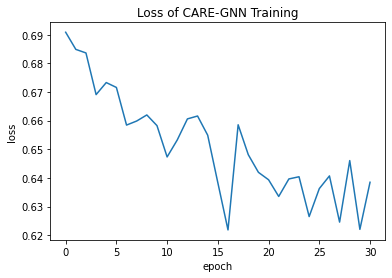

In [26]:
# plt loss
plt.plot(loss_dict.keys(), loss_dict.values())
plt.title("Loss of CARE-GNN Training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

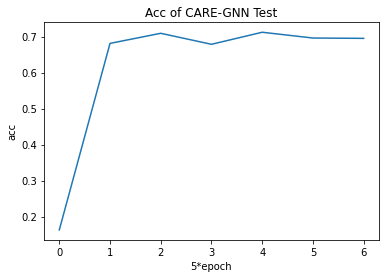

In [27]:
# plt acc
plt.plot(label_dict["acc"].keys(), label_dict["acc"].values())
plt.title("Acc of CARE-GNN Test")
plt.xlabel("5*epoch")
plt.ylabel("acc")
plt.show()

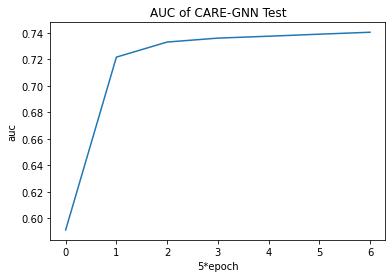

In [28]:
# plt auc
plt.plot(label_dict["auc"].keys(), label_dict["auc"].values())
plt.title("AUC of CARE-GNN Test")
plt.xlabel("5*epoch")
plt.ylabel("auc")
plt.show()

In [29]:
### Save the result

In [30]:
# label_pre
label_dict,label_actual,label_prediction,label_index = test_care(idx_test, y_test, gnn_model, args.batch_size,label_dict,count)

GNN F1: 0.6131
GNN Accuracy: 0.7162
GNN Recall: 0.7055
GNN auc: 0.7716
GNN ap: 0.3819
Label1 F1: 0.5897
Label1 Accuracy: 0.6949
Label1 Recall: 0.6767
Label1 auc: 0.7404
Label1 ap: 0.3258


In [31]:
# ensure the number
print(np.sum((label_prediction)))
print(np.sum((label_actual)))
label_pre_class = []
for i in label_prediction:
    if i == 1:
        label_pre_class.append(1)
    else:
        label_pre_class.append(0)

9628
4006


In [32]:
# establish the dataframe
# label_pre is predicted label, y_test is actual lable
df = pd.DataFrame(feat_data[label_index],columns = ["x"+str(i) for i in range(1,33)])
df["y_pre"] = label_prediction
df["y_act"] = label_actual
df["y_index"] = label_index
df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x26,x27,x28,x29,x30,x31,x32,y_pre,y_act,y_index
0,0.017965,0.011535,0.022021,0.051368,0.051368,0.020468,0.026217,0.009174,0.014073,0.051369,...,0.049069,0.001789,0.005111,0.001022,0.049835,0.034246,0.048046,1,0,35042
1,0.014100,0.017370,0.020321,0.047402,0.047402,0.047402,0.026009,0.039420,0.040060,0.020663,...,0.016980,0.031130,0.035139,0.010141,0.018159,0.020518,0.015093,0,0,27485
2,0.042462,0.012869,0.021116,0.049258,0.049258,0.049258,0.002402,0.005542,0.008837,0.049259,...,0.004411,0.049014,0.049014,0.049014,0.001715,0.006862,0.000490,1,0,16164
3,0.007178,0.020437,0.023732,0.055359,0.055359,0.055359,0.038893,0.010172,0.010822,0.055360,...,0.047373,0.006886,0.013771,0.016250,0.037182,0.022034,0.036356,0,0,21204
4,0.046861,0.016948,0.023448,0.054697,0.054697,0.021795,0.007877,0.024835,0.005684,0.054697,...,0.004898,0.054425,0.054425,0.054425,0.001905,0.007620,0.007075,1,0,12201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27568,0.036923,0.029360,0.047902,0.047902,0.047902,0.047902,0.047902,0.045220,0.033264,0.005496,...,0.014299,0.012631,0.018827,0.000238,0.015014,0.017636,0.040991,0,0,38279
27569,0.011416,0.020650,0.020911,0.048779,0.048779,0.048779,0.011533,0.018325,0.048287,0.024209,...,0.021842,0.031549,0.030093,0.038829,0.027181,0.015774,0.020871,0,0,16412
27570,0.028361,0.036436,0.045241,0.045241,0.045241,0.045241,0.022035,0.039774,0.033543,0.045242,...,0.004052,0.045017,0.041640,0.037814,0.004277,0.006302,0.010354,0,0,25374
27571,0.041851,0.012203,0.020350,0.047471,0.047471,0.018915,0.047471,0.043694,0.007262,0.004653,...,0.004251,0.047235,0.043693,0.038969,0.004487,0.006613,0.025507,1,0,22633


### Evaluate

In [33]:
#evaluate
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_true = label_actual
y_pred = label_prediction
judge = classification_report(y_true, y_pred)
print(judge)

              precision    recall  f1-score   support

           0       0.92      0.70      0.80     23567
           1       0.27      0.65      0.38      4006

    accuracy                           0.69     27573
   macro avg       0.60      0.68      0.59     27573
weighted avg       0.83      0.69      0.74     27573



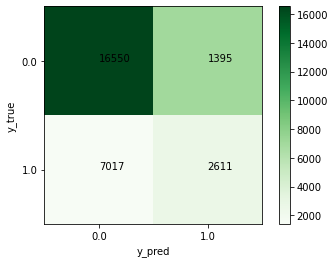

In [34]:
#confusion matrix
classes = [0.0,1.0]
confusion = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
plt.imshow(confusion, cmap=plt.cm.Greens)
indices = range(len(confusion))
plt.xticks(indices, classes)
plt.yticks(indices, classes)
plt.colorbar()
plt.xlabel('y_pred')
plt.ylabel('y_true')
for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index])
plt.show()

In [35]:
# save the df
df.to_excel("test_result.xlsx")

### Explanation

In [36]:
import numpy as np
from datetime import datetime
import pandas as pd 
import time
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
from tqdm import tqdm
import warnings
import xlwt
warnings.filterwarnings('ignore')

In [37]:
import seaborn as sns
import xgboost as xgb
from sklearn import metrics
from  sklearn.datasets  import  make_hastie_10_2
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit  
from sklearn.preprocessing import StandardScaler    

In [38]:
#show df
df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x26,x27,x28,x29,x30,x31,x32,y_pre,y_act,y_index
0,0.017965,0.011535,0.022021,0.051368,0.051368,0.020468,0.026217,0.009174,0.014073,0.051369,...,0.049069,0.001789,0.005111,0.001022,0.049835,0.034246,0.048046,1,0,35042
1,0.014100,0.017370,0.020321,0.047402,0.047402,0.047402,0.026009,0.039420,0.040060,0.020663,...,0.016980,0.031130,0.035139,0.010141,0.018159,0.020518,0.015093,0,0,27485
2,0.042462,0.012869,0.021116,0.049258,0.049258,0.049258,0.002402,0.005542,0.008837,0.049259,...,0.004411,0.049014,0.049014,0.049014,0.001715,0.006862,0.000490,1,0,16164
3,0.007178,0.020437,0.023732,0.055359,0.055359,0.055359,0.038893,0.010172,0.010822,0.055360,...,0.047373,0.006886,0.013771,0.016250,0.037182,0.022034,0.036356,0,0,21204
4,0.046861,0.016948,0.023448,0.054697,0.054697,0.021795,0.007877,0.024835,0.005684,0.054697,...,0.004898,0.054425,0.054425,0.054425,0.001905,0.007620,0.007075,1,0,12201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27568,0.036923,0.029360,0.047902,0.047902,0.047902,0.047902,0.047902,0.045220,0.033264,0.005496,...,0.014299,0.012631,0.018827,0.000238,0.015014,0.017636,0.040991,0,0,38279
27569,0.011416,0.020650,0.020911,0.048779,0.048779,0.048779,0.011533,0.018325,0.048287,0.024209,...,0.021842,0.031549,0.030093,0.038829,0.027181,0.015774,0.020871,0,0,16412
27570,0.028361,0.036436,0.045241,0.045241,0.045241,0.045241,0.022035,0.039774,0.033543,0.045242,...,0.004052,0.045017,0.041640,0.037814,0.004277,0.006302,0.010354,0,0,25374
27571,0.041851,0.012203,0.020350,0.047471,0.047471,0.018915,0.047471,0.043694,0.007262,0.004653,...,0.004251,0.047235,0.043693,0.038969,0.004487,0.006613,0.025507,1,0,22633


### Split

In [39]:
# df2 is after feature selection
df2 = df.copy()
# generate x,y
X = df2.drop(["y_pre","y_index","y_act"], axis = 1)
y = df2['y_pre']
# split to train and test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

### Train to predict the predicted label

[09:32:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.82432	val-auc:0.82295
[1]	train-auc:0.90440	val-auc:0.89355
[2]	train-auc:0.90719	val-auc:0.90031
[3]	train-auc:0.92595	val-auc:0.92104
[4]	train-auc:0.93157	val-auc:0.92772
[5]	train-auc:0.94053	val-auc:0.93709
[6]	train-auc:0.94925	val-auc:0.94495
[7]	train-auc:0.95427	val-auc:0.94886
[8]	train-auc:0.95404	val-auc:0.94802
[9]	train-auc:0.95456	val-auc:0.94833
[10]	train-auc:0.95734	val-auc:0.95106
[11]	train-auc:0.95993	val-auc:0.95395
[12]	train-auc:0.96385	val-auc:0.95770
[13]	train-auc:0.96556	val-auc:0.95991
[14]	train-auc:0.96648	val-auc:0.96085
[15]	train-auc:0.96656	val-auc:0.96111
[1

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

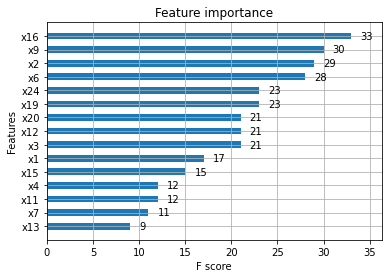

In [40]:
# load model 
pre_model = None

data_train = xgb.DMatrix(X_train, y_train)  # 使用XGBoost的原生版本需要对数据进行转化
data_val = xgb.DMatrix(X_val, y_val)
param = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',  # multi-classification algorithm
    #'objective': 'binary:logistic', # binary-classification algorithm
    #'num_class': 7,               # set number of classes needed to classify, if using the softmax function, it needed to be set
    'gamma': 0.2,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree.Generally setting 0.1,0.2
    'max_depth': 3,               # Maximum depth of a tree. Increasing value will make more complex and may likely to overfit
    'lambda': 0.4,                 # L2 regularization term on weights. Can avoid the model overfitting.
    'alpha':12,                    # L1 regularization term on weights. Increasing this value will make model more conservative.
    'subsample': 0.2,              # ratio of the training instances.  Randomly sample of the training data by using this ratio and prior to growing trees. It used to prevent overfitting.
    'colsample_bytree': 0.5,       # the subsample ratio of columns when constructing each tree
    'min_child_weight': 1,         # Minimum sum of instance weight (hessian) needed in a child
    "max_delta_step":0,            # Maximum delta step we allow each leaf output to be
    'eta': 0.2,                    # it seems like learning rate.
    #"scale_pos_weight":1,         #benifit converge quickly in unbalance situation
    'silent': 0,                   # if setting on 1, it would no have executed information output, the better way is set to 0
    'nthread': 4,                  # Number of parallel threads used to run XGBoost
    #"min_child_weight":1,          #minimum subtree
    "eval_metric": ["auc"] #can combine to use the function of evaluate the data.
}

watchlist = [(data_train, 'train'),(data_val, 'val')]
n_round = 50
evals_result={}
booster = xgb.train(param, data_train,num_boost_round = n_round,evals = watchlist,xgb_model = pre_model,evals_result=evals_result)

# get importance
plot_importance(booster,
                 height=0.5,
                 max_num_features=15)

# save the model
#booster.save_model('./model/xgb.model')

### Train to predict the incorrected predicted label

In [41]:
# df2 is after feature selection
df2 = df.copy()
df2["judge_false"] = abs(df2["y_pre"] - df2["y_act"])

In [42]:
# df2 is after feature selection
# generate x,y
X = df2.drop(["y_pre","y_index","y_act","judge_false"], axis = 1)
y = df2['judge_false']
# split to train and test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

[09:32:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.73961	val-auc:0.72479
[1]	train-auc:0.78562	val-auc:0.77605
[2]	train-auc:0.79332	val-auc:0.78522
[3]	train-auc:0.80665	val-auc:0.79894
[4]	train-auc:0.80542	val-auc:0.79756
[5]	train-auc:0.82285	val-auc:0.81493
[6]	train-auc:0.82477	val-auc:0.81470
[7]	train-auc:0.83124	val-auc:0.82149
[8]	train-auc:0.83421	val-auc:0.82489
[9]	train-auc:0.83679	val-auc:0.82737
[10]	train-auc:0.83798	val-auc:0.82861
[11]	train-auc:0.84006	val-auc:0.83124
[12]	train-auc:0.84295	val-auc:0.83293
[13]	train-auc:0.84571	val-auc:0.83519
[14]	train-auc:0.84681	val-auc:0.83623
[15]	train-auc:0.84876	val-auc:0.83820
[1

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

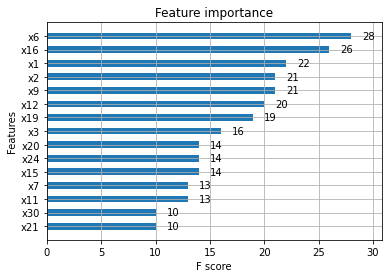

In [43]:
# load model 
pre_model = None

data_train = xgb.DMatrix(X_train, y_train)  # 使用XGBoost的原生版本需要对数据进行转化
data_val = xgb.DMatrix(X_val, y_val)
param = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',  # multi-classification algorithm
    #'objective': 'binary:logistic', # binary-classification algorithm
    #'num_class': 7,               # set number of classes needed to classify, if using the softmax function, it needed to be set
    'gamma': 0.2,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree.Generally setting 0.1,0.2
    'max_depth': 3,               # Maximum depth of a tree. Increasing value will make more complex and may likely to overfit
    'lambda': 0.4,                 # L2 regularization term on weights. Can avoid the model overfitting.
    'alpha':12,                    # L1 regularization term on weights. Increasing this value will make model more conservative.
    'subsample': 0.2,              # ratio of the training instances.  Randomly sample of the training data by using this ratio and prior to growing trees. It used to prevent overfitting.
    'colsample_bytree': 0.5,       # the subsample ratio of columns when constructing each tree
    'min_child_weight': 1,         # Minimum sum of instance weight (hessian) needed in a child
    "max_delta_step":0,            # Maximum delta step we allow each leaf output to be
    'eta': 0.2,                    # it seems like learning rate.
    #"scale_pos_weight":1,         #benifit converge quickly in unbalance situation
    'silent': 0,                   # if setting on 1, it would no have executed information output, the better way is set to 0
    'nthread': 4,                  # Number of parallel threads used to run XGBoost
    #"min_child_weight":1,          #minimum subtree
    "eval_metric": ["auc"] #can combine to use the function of evaluate the data.
}

watchlist = [(data_train, 'train'),(data_val, 'val')]
n_round = 50
evals_result={}
booster = xgb.train(param, data_train,num_boost_round = n_round,evals = watchlist,xgb_model = pre_model,evals_result=evals_result)

# get importance
plot_importance(booster,
                 height=0.5,
                 max_num_features=15)

# save the model
#booster.save_model('./model/xgb.model')